In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
42,4.4,3.2,1.3,0.2,Iris-setosa
72,6.3,2.5,4.9,1.5,Iris-versicolor
105,7.6,3.0,6.6,2.1,Iris-virginica
132,6.4,2.8,5.6,2.2,Iris-virginica
141,6.9,3.1,5.1,2.3,Iris-virginica
...,...,...,...,...,...
80,5.5,2.4,3.8,1.1,Iris-versicolor
49,5.0,3.3,1.4,0.2,Iris-setosa
109,7.2,3.6,6.1,2.5,Iris-virginica
21,5.1,3.7,1.5,0.4,Iris-setosa


In [3]:
labels_column_name = "label"
jackknife_idx = np.random.randint(0, iris_dataset.shape[0])
train_set = iris_dataset.loc[
        iris_dataset.index != jackknife_idx
    ].drop(columns=labels_column_name).values
train_labels = iris_dataset.loc[
        iris_dataset.index != jackknife_idx,
        labels_column_name
    ].values
test_set = iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ].drop(columns=labels_column_name).values
test_labels = iris_dataset.loc[
        iris_dataset.index == jackknife_idx,
        labels_column_name
    ].values
test_instance = test_set[0]

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 10)
random_forest.fit(train_set, train_labels)
unique_labels = random_forest.classes_

prediction = random_forest.predict(test_set)
prediction_probabilities = random_forest.predict_proba(test_set)
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-setosa']. Probabilities: [[1. 0. 0.]]


### Use LIME to explain prediction

,sepal_length,sepal_width,petal_length,petal_width,label
10,5.4,3.7,1.5,0.2,Iris-setosa


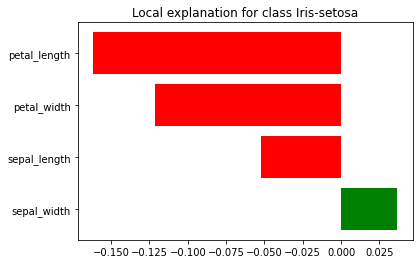

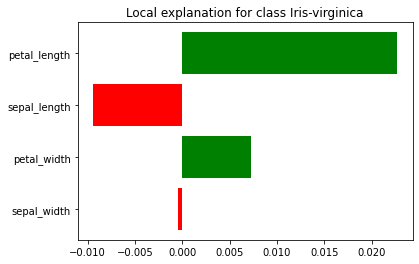

In [4]:
importlib.reload(lime.lime_tabular_mod)
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = unique_labels,
    discretize_continuous=False,
    sample_around_instance=True
)
explanation = explainer.explain_instance(
    test_instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3,
    distance_metric="minkowski",
    minkowski_norm=100.
)
for label in explanation.top_labels[:2]:
    _ = explanation.as_pyplot_figure(label)
iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ]

In [5]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))
print(explanation.get_scores_for_surrogate_model())
print(explanation.get_losses_for_surrogate_model())
print(explanation.get_fidelity_loss_on_explanation())
print(explanation.get_fidelity_loss_on_generated_data())


[1. 0. 0.]
[0.7438340489438812, 0.24201937548368258, 0.01414657557243653]
[0.47904407 0.29002813 0.2309278 ]
[0.562428460051387, 0.5267870617299435, 0.1868915686689956]
[0.02859057761979735, 0.028532402355208028, 0.004112704267767353]
0.13627968330654094
0.06319522710664809


array([0.13627968, 0.05672752, 0.10188095, ..., 0.07917969, 0.11146703,
       0.04995738])

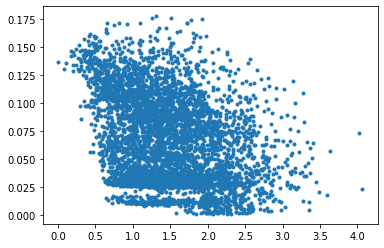

In [6]:
examples_squared_errors = np.mean(explanation.squared_errors_matrix, axis=1)
examples_distances = explanation.training_data_distances
sorted_sequence = np.argsort(examples_distances)

plt.scatter(
    examples_distances[sorted_sequence],
    examples_squared_errors[sorted_sequence],
    marker=".")

examples_squared_errors

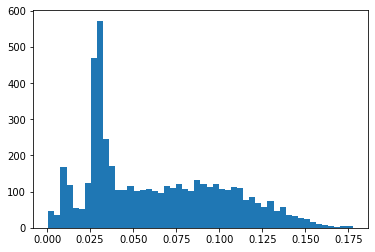

In [7]:
plt.hist(examples_squared_errors, bins=50)
plt.show()

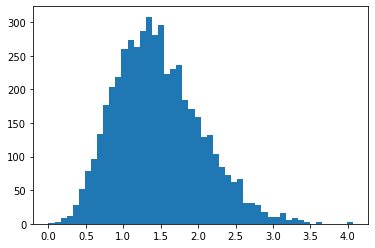

In [8]:
plt.hist(examples_distances, bins=50)
plt.show()

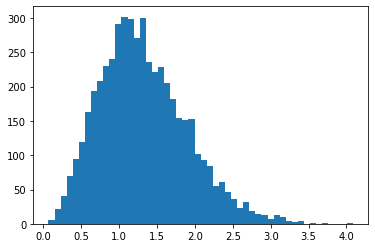

In [9]:
N = 5000
dim = 3

x = np.random.normal(0, 1, N*dim).reshape(N, dim)
y = np.zeros(shape=(1, dim))
d = sklearn.metrics.pairwise_distances(
    x,
    y,
    metric="minkowski",
    p=100.
)
plt.hist(d, bins=50)
plt.show()
